## Here are the things we will look at :
1. Reading and analyzing data. (Pandas)
2. Normalizing the data. (SkLearn)
3. Converting data to time-series and supervised learning problem.
4. Creating model (Keras)
5. Fine tuning the model (in the next article)
6. Training, predicting and visualizing the result.
7. Tips & tools that I found very helpful (last article of the series)

## 1. Reading and analyzing data

In [133]:
import os, pandas as pd
# Add asset from file system
df_data_1 = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/TSLA.csv')
df_data_1.head()



Date       Open      High        Low      Close  Adj Close  Volume
0  2000-05-26  45.531250  45.71875  45.312500  45.718750  35.550995   74800
1  2000-05-30  46.375000  47.40625  46.375000  47.406250  36.863197   57600
2  2000-05-31  47.562500  48.18750  47.562500  47.578125  36.996853   36000
3  2000-06-01  48.554688  48.65625  48.554688  48.656250  37.835213    7000
4  2000-06-02  50.859375  51.18750  50.859375  51.187500  39.803505   29400

In [2]:
!pip install pandas_datareader

You should consider upgrading via the 'pip install --upgrade pip' command.


## Optionally  you can also use Pandas_datareader to get stock price history

In [95]:
import pandas as pd
from pandas_datareader import data, wb   # Package and modules for importing data; this code may change depending on pandas version
import datetime
 
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()
 
# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
microsoft = data.DataReader("MSFT", "yahoo", start, end)
google = data.DataReader("GOOG", "yahoo", start, end)
apple = data.DataReader("AAPL", "yahoo", start, end)
aws = data.DataReader("AMZN", "yahoo", start, end)
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({ "AWS": aws["Adj Close"],
                        "AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})


In [96]:
stocks.head()

AAPL         AWS        GOOG       MSFT
Date                                                    
2016-01-04  98.742249  636.989990  741.840027  50.708462
2016-01-05  96.267815  633.789978  742.580017  50.939793
2016-01-06  94.383888  632.650024  743.619995  50.014458
2016-01-07  90.400467  607.940002  726.390015  48.274826
2016-01-08  90.878479  607.049988  714.469971  48.422878

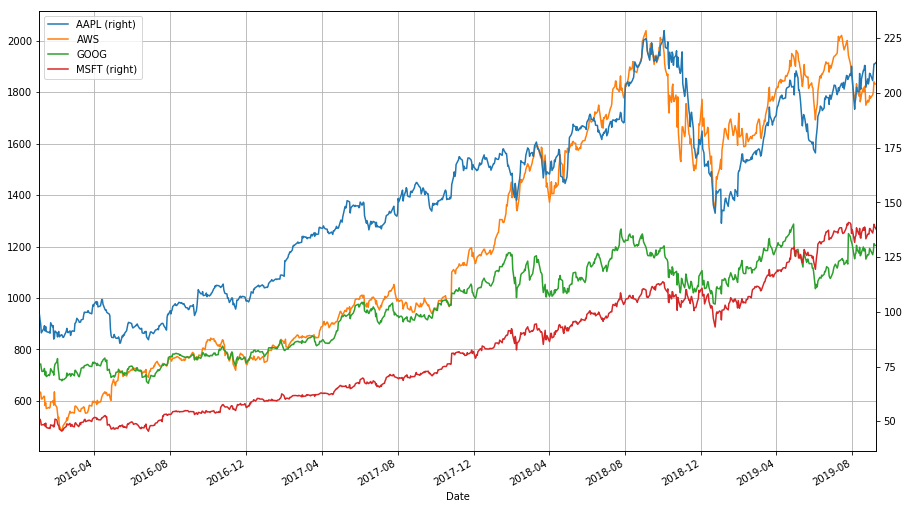

In [97]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)


### Setting the parameter

In [218]:
params = {
    "batch_size": 15,  # 20<16<10, 25 was a bust
    "epochs": 10,
    "lr": 0.00010000,
    "time_steps": 60
}

In [192]:
iter_changes = "dropout_layers_0.4_0.4"

OUTPUT_PATH = "outputs/"
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

In [200]:
import os
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    print("Directory created", OUTPUT_PATH)
else:
    print("Directory already exists. Don't override.")

Directory already exists. Don't override.


### Define functions

In [201]:
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")


def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat


def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

### Reading the data

In [202]:

#df_data_2= pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/TSLA.csv',
#                                    parse_dates=['Date'],
#                                    index_col=['Date'])

df_data_2=pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/TSLA.csv')
df_data_2.head()

Date       Open      High        Low      Close  Adj Close  Volume
0  2000-05-26  45.531250  45.71875  45.312500  45.718750  35.550995   74800
1  2000-05-30  46.375000  47.40625  46.375000  47.406250  36.863197   57600
2  2000-05-31  47.562500  48.18750  47.562500  47.578125  36.996853   36000
3  2000-06-01  48.554688  48.65625  48.554688  48.656250  37.835213    7000
4  2000-06-02  50.859375  51.18750  50.859375  51.187500  39.803505   29400

In [203]:
df = df_data_2
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [204]:
df.shape

(4851, 7)

## Plotting the data

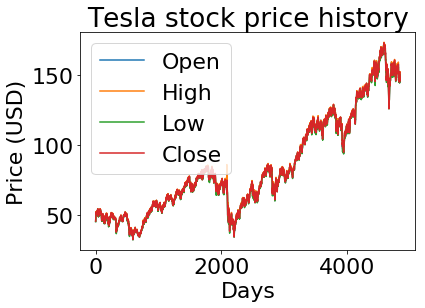

In [205]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df["Open"])
plt.plot(df["High"])
plt.plot(df["Low"])
plt.plot(df["Close"])
plt.title('Tesla stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

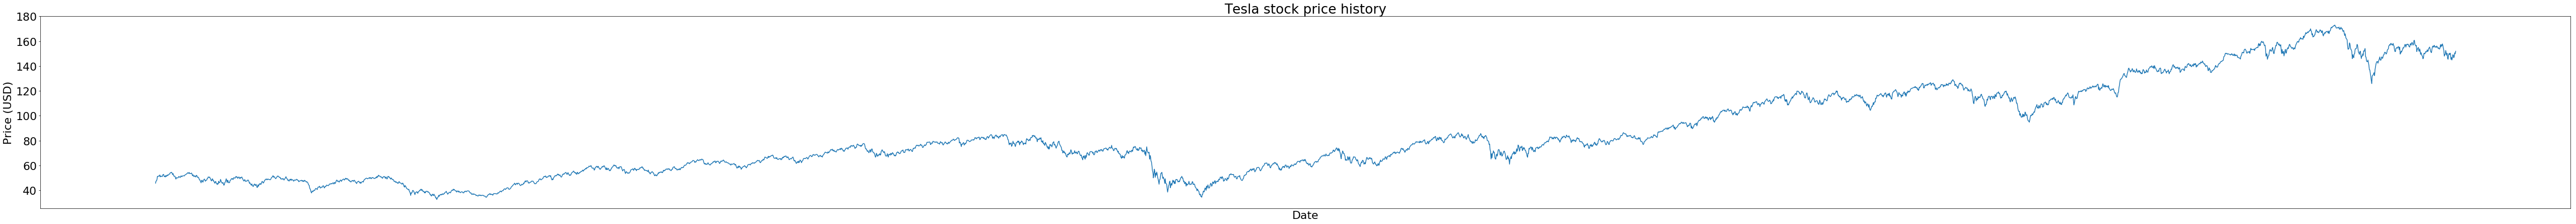

In [206]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
months_fmt = mdates.DateFormatter('%M')


fig, ax = plt.subplots(figsize=(90, 7))
plt.rcParams.update({'font.size': 22})


# Add the x-axis and the y-axis to the plot
ax.plot(df.index.values,
        df['Close'])


# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Price (USD)",
       title="Tesla stock price history")


ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(35) 



plt.show()

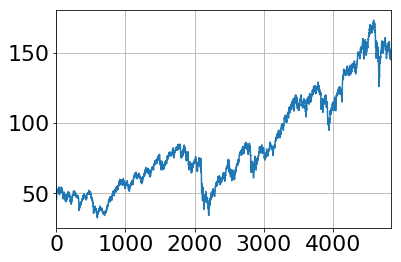

In [207]:
df["Close"].plot(grid = True)


### Checking to see whether we have any NULL value to worry about

In [208]:
# Checking if any null values are present\n"
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Luckyly we do not have any NULL value

### Spliting the data 80/20

In [209]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size: ", len(df_train), len(df_test))

Train and Test size:  3880 971


### Normalizing the data
The data is not normalized and the range for each column varies, especially Volume. Normalizing data helps the algorithm in converging i.e. to find local/ global minimum efficiently. I will use MinMaxScaler from Sci-kit Learn. Also I will convert the DataFrame to ndarray in the process.

In [210]:
from sklearn.preprocessing import MinMaxScaler

train_cols = ["Open","High","Low","Close","Volume"]

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
x_train.shape()

TypeError: 'tuple' object is not callable

In [211]:
x_train.shape

(3880, 5)

In [212]:
x_test.shape

(971, 5)

## Converting data to time-series and supervised learning problem


In [213]:
import numpy as np

x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)


dim_0 3820



length of time-series i/o (3820, 60, 5) (3820,)


### Building the model using Keras

In [214]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, LSTM, Dropout
from keras import optimizers


In [215]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

In [216]:
model = None
model = create_model()

In [217]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import time

r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, verbose=0, mode='auto', cooldown=0, min_lr=0)
csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])

Train on 3820 samples, validate on 440 samples
Epoch 1/10
 - 25s - loss: 0.0533 - val_loss: 0.1559

Epoch 00001: val_loss did not improve
Epoch 2/10
 - 24s - loss: 0.0345 - val_loss: 0.0305

Epoch 00002: val_loss did not improve
Epoch 3/10
 - 24s - loss: 0.0126 - val_loss: 0.0227

Epoch 00003: val_loss did not improve
Epoch 4/10
 - 24s - loss: 0.0081 - val_loss: 0.0214

Epoch 00004: val_loss did not improve
Epoch 5/10
 - 23s - loss: 0.0070 - val_loss: 0.0204

Epoch 00005: val_loss did not improve
Epoch 6/10
 - 24s - loss: 0.0067 - val_loss: 0.0199

Epoch 00006: val_loss did not improve
Epoch 7/10
 - 23s - loss: 0.0061 - val_loss: 0.0199

Epoch 00007: val_loss did not improve
Epoch 8/10
 - 23s - loss: 0.0058 - val_loss: 0.0197

Epoch 00008: val_loss did not improve
Epoch 9/10
 - 24s - loss: 0.0054 - val_loss: 0.0192

Epoch 00009: val_loss did not improve
Epoch 10/10
 - 24s - loss: 0.0051 - val_loss: 0.0190

Epoch 00010: val_loss did not improve


In [219]:
 #save model
import h5py
model.save(filepath="Tesla_lstm_model")

### Use differnent way to traing the model

In [220]:
print(y_t)

[0.19807435 0.19726443 0.20520166 ... 0.85538049 0.84231814 0.87673655]


In [221]:
!ls


AAPLPricePrediction.jupyter-py35.ipynb
best_model.h5
my_model_with_mae_60_ts.h5
outputs
Tesla_lstm_model
TeslaStockPriceModeTest.jupyter-py35.ipynb
TeslaStockPricePrediction-LSTM.jupyter-py35.ipynb
training_log_Tue_Sep_10_05:46:38_2019.log
training_log_Tue_Sep_10_05:48:02_2019.log
training_log_Tue_Sep_10_07:44:07_2019.log
train_vis_BS_20_Tue Sep 10 09:09:12 2019.png
train_vis_BS_64_Tue Sep 10 06:01:00 2019.png
train_vis_BS_64_Tue Sep 10 06:39:42 2019.png
train_vis_BS_64_Tue Sep 10 06:45:31 2019.png


### Model evaluation

In [222]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

dim_0 911



length of time-series i/o (911, 60, 5) (911,)


In [223]:
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

Test size (450, 60, 5) (450,) (450, 60, 5) (450,)


In [224]:
### load the model
#load model
from keras.models import load_model
model = load_model(filepath="Tesla_lstm_model")
print("Loaded saved model...")

Loaded saved model...


In [225]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)


In [226]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])


Error is 0.11685085820924533 (440,) (440,)
[0.93579376 0.9358819  0.93594414 0.93598473 0.9360193  0.93603677
 0.9360369  0.93601483 0.9360068  0.9360117  0.9360394  0.9361007
 0.93619275 0.93629736 0.9364053 ]
[1.18650224 1.1885756  1.18318473 1.1820445  1.18245912 1.17831239
 1.17229951 1.19448486 1.20153434 1.21273072 1.22890319 1.22682982
 1.22745182 1.22268309 1.24725282]


In [227]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[122.816666 122.825165 122.83118  122.83508  122.838425 122.8401
 122.84012  122.83798  122.83722  122.83768  122.84036  122.84627
 122.85515  122.865234 122.875656]
[147.       147.199997 146.679993 146.570007 146.610001 146.210007
 145.630005 147.770004 148.449997 149.529999 151.089996 150.889999
 150.949997 150.490005 152.860001]


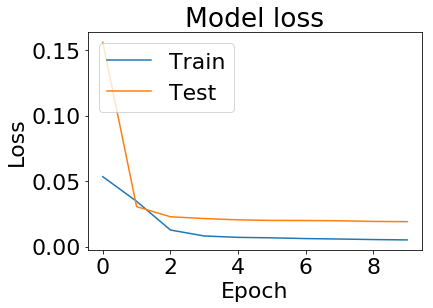

In [228]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join("", 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))


In [229]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])


Error is 0.11676345583254562 (440,) (440,)
[0.9394269  0.93948734 0.9395254  0.93954265 0.93955445 0.93954927
 0.9395293  0.9394897  0.9394648  0.9394549  0.9394681  0.93951225
 0.9395854  0.93966925 0.93975854]
[1.18650224 1.1885756  1.18318473 1.1820445  1.18245912 1.17831239
 1.17229951 1.19448486 1.20153434 1.21273072 1.22890319 1.22682982
 1.22745182 1.22268309 1.24725282]
[123.167114 123.17294  123.17662  123.17828  123.17943  123.178925
 123.177    123.17317  123.17078  123.169815 123.1711   123.175354
 123.1824   123.19049  123.19911 ]
[147.       147.199997 146.679993 146.570007 146.610001 146.210007
 145.630005 147.770004 148.449997 149.529999 151.089996 150.889999
 150.949997 150.490005 152.860001]


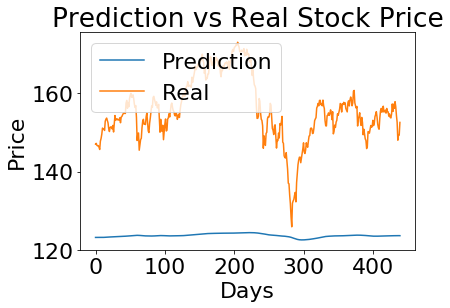

In [230]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
